In [28]:
from torchvision import datasets, transforms
import torch

dataset_train_t = datasets.CIFAR10('.', train = True, download = False, transform = transforms.ToTensor())
dataset_val_t = datasets.CIFAR10('.', train = False, download = False, transform = transforms.ToTensor())

imgs = torch.stack([img_t for img_t,_ in dataset_train_t], dim=3)
[m1,m2,m3] = imgs.view(3,-1).mean(dim=1).numpy()
[s1,s2,s3] = imgs.view(3,-1).std(dim=1).numpy()
dataset_train_transformed = datasets.CIFAR10('.', train = True, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))
dataset_val_transformed = datasets.CIFAR10('.', train = False, download = False,
                                            transform = transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((m1,m2,m3), (s1,s2,s3))
                                            ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
dataset_train = [(img, label_map[label]) for (img, label) in dataset_train_transformed if label in [0,2]]
dataset_val = [(img, label_map[label]) for (img, label) in dataset_val_transformed if label in [0,2]]
print(len(dataset_train), len(dataset_val))

10000 2000


In [24]:
import torch.nn as nn
conv= nn.Conv2d(3, 16, kernel_size = 3) # 3 input channels (RGB), 16 output channels, 3*3 kernel size, 1*1 stride
print(conv.weight.shape, conv.bias.shape) # bias of conv is the same size as output channels, one bias value per output channel

torch.Size([16, 3, 3, 3]) torch.Size([16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) torch.Size([1, 16, 32, 32])
torch.Size([32, 32])


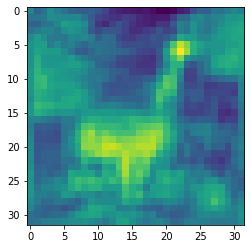

In [98]:
img_t, lbl = dataset_train[0]
out = conv(img_t.unsqueeze(0)) #conv works on B*C*H*W dimensions so image must be extended on 0th dim
print(img_t.shape, out.shape)

from matplotlib import pyplot as plt
plt.imshow(img_t.permute(1,2,0))
plt.imshow(out[0,0].detach().numpy()) #try out[0,0], out[0,1] ... out[0,15]
print(out[0,0].shape) # 30 * 30 in 0th output channel, no padding reduces the size

torch.Size([1, 16, 32, 32])


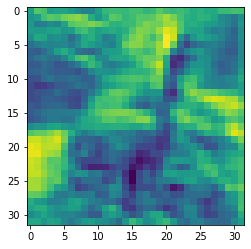

In [99]:
conv = nn.Conv2d(3, 16, kernel_size = 3, padding = 1) #add 1 pixel to the border of images
out = conv(img_t.unsqueeze(0))
print(out.shape)
plt.imshow(out[0,0].detach())

In [100]:
#downsampling
pool = nn.MaxPool2d(2) #2*2 max pooling
print(pool(img_t).shape)

torch.Size([3, 16, 16])


In [111]:
#input: 1 * 3 * 32 * 32
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1), #output: 1 * 16 * 32 * 32
                     nn.Tanh(), #output: 1 * 16 * 32 * 32
                     nn.MaxPool2d(2), #output: 1 * 16 * 16 * 16
                     nn.Conv2d(16, 8, kernel_size=3, padding=1), #output: 1 * 8 * 16 * 16
                     nn.Tanh(), #output: 1 * 8 * 16 * 16
                     nn.MaxPool2d(2), #output: 1 * 8 * 8 * 8
                     nn.Flatten(), # output: 1 * 512
                     nn.Linear(8*8*8, 32), #output: 1 * 32
                     nn.Tanh(), #output: 1 * 32
                     nn.Linear(32,2) # output: 1 * 2
                     )
print([p.numel() for p in model.parameters()]) #1st Conv2d: 16*3*3*3 weights, 16 biases
                                               #2nd Conv2: 8*16*3*3 weights, 8 biases
                                               #1st Linear: 8*8*8*32 weights, 32 biases
                                               #2nd Linear: 32*2 wieghts, 2 biases 
model(img_t.unsqueeze(0))

[432, 16, 1152, 8, 16384, 32, 64, 2]


tensor([[-0.0258,  0.2468]], grad_fn=<AddmmBackward>)

In [115]:
#a nn.Module subclass with user-defined functionalities
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32,2)
    
    def forward(self,x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out.view(-1, 8*8*8) # does the flattening: 1 * 512
        out = self.fc2(self.act3(self.fc1(out)))
        return out

model = Net()
[p.numel() for p in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [132]:
#nn.Tanh() and nn.MaxPool2d do not have parameters to be trained. 
#Using functional to define them as functions in the submodule

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear(512,32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh((self.conv1(x))), 2)
        out = F.max_pool2d(torch.tanh((self.conv2(out))), 2)
        out = out.view(-1, 8*8*8)
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

model = Net()
print([p.numel() for p in model.parameters()])

model(img_t.unsqueeze(0))
#img_t.unsqueeze(0).shape

[432, 16, 1152, 8, 16384, 32, 64, 2]


tensor([[-0.0187, -0.1943]], grad_fn=<AddmmBackward>)

In [141]:
import datetime

def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1 + n_epochs):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            outs = model(imgs) 
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if epoch%10 == 0:
            print('{} Epoch {}, train loss {}'.format(
                datetime.datetime.now(), epoch, train_loss/len(train_loader)))
    

In [142]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=False)
train_val = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

training_loop(n_epochs = 100,
              model = model,
              loss_fn = loss_fn,
              optimizer = optimizer,
              train_loader = train_loader)

2022-03-31 18:48:52.377523 Epoch 0, train loss 0.5448620315569981
2022-03-31 18:49:15.665628 Epoch 10, train loss 0.3203405313620901
2022-03-31 18:49:38.413801 Epoch 20, train loss 0.2916752137006468
2022-03-31 18:50:01.886135 Epoch 30, train loss 0.2709023571887593
2022-03-31 18:50:25.165701 Epoch 40, train loss 0.2510178666205923
2022-03-31 18:50:48.270274 Epoch 50, train loss 0.23231424770917103
2022-03-31 18:51:11.108978 Epoch 60, train loss 0.21464032219473722
2022-03-31 18:51:34.550012 Epoch 70, train loss 0.19863395772542164
2022-03-31 18:51:58.315597 Epoch 80, train loss 0.18403831741232782
2022-03-31 18:52:21.178654 Epoch 90, train loss 0.1704572924430583
2022-03-31 18:52:43.892321 Epoch 100, train loss 0.15742178807023224
